In [ ]:
# Project configuration - use absolute paths
from pathlib import Path
import sys
PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))
print(f"Project root: {PROJECT_ROOT}")

# MNIST Text-to-Image Diffusion: Evaluation Metrics

This notebook computes MNIST-specific evaluation metrics for the text-to-image diffusion model.

## What we'll compute:
1. **MNIST-FID**: FID using features from an MNIST-trained classifier (better than Inception-FID for MNIST)
2. **Real-vs-real baseline**: FID between two real MNIST subsets (noise floor)
3. **Conditional accuracy**: Does the generated image match the prompt digit?
4. **Per-digit accuracy breakdown**

## Prerequisites:
- Run `inference1_t2i_mnist_cfg.ipynb` first to set up the model
- Or ensure you have a trained diffusion model checkpoint

In [1]:
import scipy
import torch
from diffusers import DDPMScheduler
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel
import os
import glob
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from scipy import linalg
from torchvision.datasets import MNIST
import torch.nn.functional as F
import numpy as np

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom UNet2DConditionModel with reduced parameters
class CustomUNet2DConditionModel(UNet2DConditionModel):
    def __init__(self, **kwargs):
        super().__init__(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,  # Reduced from default
            block_out_channels=(32, 64, 64, 32),  # Reduced from default
            down_block_types=(
                "DownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "UpBlock2D",
            ),
            cross_attention_dim=512,  # CLIP embedding dimension
            **kwargs
        )

# Load models
unet = CustomUNet2DConditionModel().to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Set to eval mode
text_encoder.requires_grad_(False)
text_encoder.eval()

TOKENIZER_MAX_LENGTH = 8

Using device: cuda


In [ ]:
# Load checkpoint

# Use absolute path from PROJECT_ROOT
checkpoint_dir = PROJECT_ROOT / "checkpoints"

if not checkpoint_dir.exists():
    print(f"Checkpoint directory not found: {checkpoint_dir}")
    print(f"Current working directory: {os.getcwd()}")
    raise FileNotFoundError("No checkpoint directory found. Please train the model first.")

# Look for checkpoint files
pattern = str(checkpoint_dir / "train1_unet_checkpoint_epoch_*.pt")
checkpoints = glob.glob(pattern)

if not checkpoints:
    print(f"No checkpoint files found in {checkpoint_dir}")
    files = list(checkpoint_dir.glob("*"))
    print(f"Contents: {files[:5]}{'...' if len(files) > 5 else ''}")
    raise FileNotFoundError("No checkpoint files found. Please train the model first.")

print(f"Found checkpoint directory: {checkpoint_dir}")
print(f"Found {len(checkpoints)} checkpoint files")

# Sort by epoch number and get the latest
latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("_")[-1].split(".")[0]))
print(f"Loading checkpoint: {latest_checkpoint}")

checkpoint = torch.load(latest_checkpoint, map_location=device)
unet.load_state_dict(checkpoint["unet_state_dict"])
print(f"Loaded model from epoch {checkpoint['epoch']}")

unet.eval()
print("Model loaded and ready for evaluation!")

Found checkpoint directory: /RG/rg-miray/doshlom4/final_project/checkpoints
Found 5 checkpoint files
Loading checkpoint: /RG/rg-miray/doshlom4/final_project/checkpoints/train1_unet_checkpoint_epoch_20.pt
Loaded model from epoch 20
Model loaded and ready for evaluation!


In [4]:
# Define the generation function (with classifier-free guidance)

num_inference_steps = 50

@torch.no_grad()
def generate_image(prompt, guidance_scale, num_images=1):
    """
    Generate images using the trained diffusion model with classifier-free guidance.
    
    Args:
        prompt: Text prompt
        guidance_scale: CFG guidance scale
        num_images: Number of images to generate
    
    Returns:
        images: Generated images (num_images, 1, 28, 28) in range [0, 1]
    """
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Prepare unconditioned embeddings for classifier free guidance
    uncond_input = tokenizer([""] * num_images, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Concatenate text embeddings with unconditional embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize latents
    latents = torch.randn((num_images, unet.config.in_channels, 28, 28), device=device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    for t in scheduler.timesteps:
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to image (pixel-space, no VAE)
    image = (latents / 2 + 0.5).clamp(0, 1)
    return image

## Import Evaluation Modules

Load our custom MNIST classifier and metrics modules.

In [ ]:
# Import our custom modules
# sys.path already configured at top of notebook with PROJECT_ROOT

from mnist_classifier import (
    MNISTClassifier, 
    train_mnist_classifier, 
    evaluate_mnist_classifier,
    load_mnist_classifier,
    get_mnist_dataloaders
)

from metrics_mnist_fid import (
    compute_mnist_fid,
    compute_conditional_accuracy,
    visualize_conditional_accuracy,
    plot_confusion_matrix,
    plot_fid_vs_guidance,
    plot_accuracy_vs_guidance,
    generate_evaluation_report
)

print("Evaluation modules imported successfully!")

Evaluation modules imported successfully!


## Step 1: Train or Load MNIST Classifier

We need a well-trained MNIST classifier for feature extraction. This classifier will be used to compute MNIST-FID and conditional accuracy.

Training new MNIST classifier...
This will take a few minutes...


Epoch 1/10: 100%|██████████| 469/469 [00:05<00:00, 91.16it/s, loss=0.0976, acc=93.05%] 


Epoch 1/10: Train Loss: 0.2281, Train Acc: 93.05%, Test Acc: 98.54%
Saved best model with test accuracy: 98.54%


Epoch 2/10: 100%|██████████| 469/469 [00:04<00:00, 102.32it/s, loss=0.0753, acc=97.76%]


Epoch 2/10: Train Loss: 0.0763, Train Acc: 97.76%, Test Acc: 98.90%
Saved best model with test accuracy: 98.90%


Epoch 3/10: 100%|██████████| 469/469 [00:04<00:00, 102.87it/s, loss=0.0361, acc=98.39%]


Epoch 3/10: Train Loss: 0.0554, Train Acc: 98.39%, Test Acc: 99.16%
Saved best model with test accuracy: 99.16%


Epoch 4/10: 100%|██████████| 469/469 [00:04<00:00, 101.75it/s, loss=0.0967, acc=98.63%]


Epoch 4/10: Train Loss: 0.0462, Train Acc: 98.63%, Test Acc: 99.09%


Epoch 5/10: 100%|██████████| 469/469 [00:04<00:00, 102.97it/s, loss=0.0172, acc=98.86%]


Epoch 5/10: Train Loss: 0.0371, Train Acc: 98.86%, Test Acc: 99.32%
Saved best model with test accuracy: 99.32%


Epoch 6/10: 100%|██████████| 469/469 [00:04<00:00, 102.12it/s, loss=0.0272, acc=99.04%]


Epoch 6/10: Train Loss: 0.0311, Train Acc: 99.04%, Test Acc: 99.37%
Saved best model with test accuracy: 99.37%


Epoch 7/10: 100%|██████████| 469/469 [00:04<00:00, 102.34it/s, loss=0.0299, acc=99.22%]


Epoch 7/10: Train Loss: 0.0265, Train Acc: 99.22%, Test Acc: 99.16%


Epoch 8/10: 100%|██████████| 469/469 [00:04<00:00, 102.43it/s, loss=0.0133, acc=99.24%]


Epoch 8/10: Train Loss: 0.0249, Train Acc: 99.24%, Test Acc: 99.38%
Saved best model with test accuracy: 99.38%


Epoch 9/10: 100%|██████████| 469/469 [00:04<00:00, 101.73it/s, loss=0.0023, acc=99.34%]


Epoch 9/10: Train Loss: 0.0215, Train Acc: 99.34%, Test Acc: 99.24%


Epoch 10/10: 100%|██████████| 469/469 [00:04<00:00, 101.36it/s, loss=0.0196, acc=99.31%]


Epoch 10/10: Train Loss: 0.0211, Train Acc: 99.31%, Test Acc: 99.40%
Saved best model with test accuracy: 99.40%

Classifier checkpoint saved to: /RG/rg-miray/doshlom4/final_project/checkpoints/mnist_classifier.pt


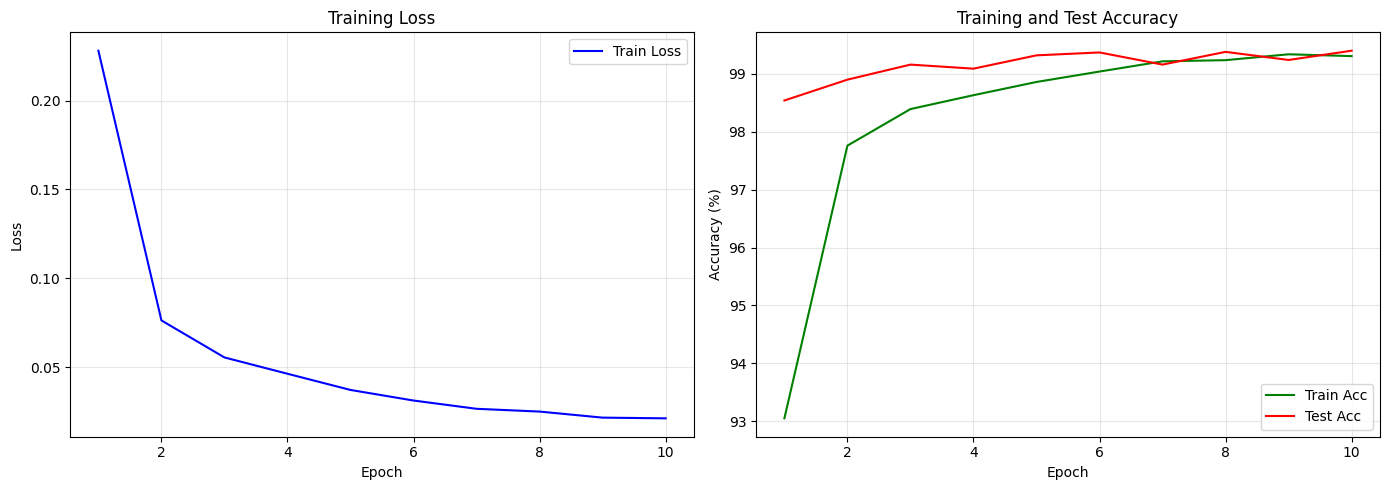


Classifier training complete!
Final test accuracy: 99.40%

MNIST Classifier ready for evaluation!
Embedding dimension: 128
Checkpoint location: /RG/rg-miray/doshlom4/final_project/checkpoints/mnist_classifier.pt


In [ ]:
# Configuration
CLASSIFIER_CHECKPOINT = str(PROJECT_ROOT / "checkpoints" / "mnist_classifier.pt")
TRAIN_NEW_CLASSIFIER = False  # Set to True if you want to train a new classifier

# Check if classifier exists
if os.path.exists(CLASSIFIER_CHECKPOINT) and not TRAIN_NEW_CLASSIFIER:
    print(f"Loading existing classifier from {CLASSIFIER_CHECKPOINT}")
    mnist_classifier, classifier_ckpt = load_mnist_classifier(CLASSIFIER_CHECKPOINT, device)
    print(f"Loaded classifier from epoch {classifier_ckpt['epoch']}")
    print(f"Test accuracy: {classifier_ckpt['test_acc']:.2f}%")
    
    # Verify on test set
    _, test_loader_clf, _, test_dataset_clf = get_mnist_dataloaders(batch_size=128, normalize_range='neg1to1')
    test_acc = evaluate_mnist_classifier(mnist_classifier, test_loader_clf, device)
    print(f"Verified test accuracy: {test_acc:.2f}%")
    
else:
    print("Training new MNIST classifier...")
    print("This will take a few minutes...")
    
    # Ensure checkpoint directory exists
    checkpoint_dir = PROJECT_ROOT / "checkpoints"
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    print(f"Created directory: {checkpoint_dir}")
    
    # Get dataloaders (normalized to [-1, 1])
    train_loader_clf, test_loader_clf, _, test_dataset_clf = get_mnist_dataloaders(
        batch_size=128, normalize_range='neg1to1'
    )
    
    # Create and train classifier
    mnist_classifier = MNISTClassifier(embedding_dim=128)
    mnist_classifier, history = train_mnist_classifier(
        mnist_classifier, train_loader_clf, test_loader_clf, device, 
        num_epochs=10, lr=0.001, checkpoint_path=CLASSIFIER_CHECKPOINT
    )
    
    # Plot training history
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs, history['train_acc'], 'g-', label='Train Acc')
    ax2.plot(epochs, history['test_acc'], 'r-', label='Test Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nClassifier training complete!")
    print(f"Final test accuracy: {history['test_acc'][-1]:.2f}%")

print(f"\nMNIST Classifier ready for evaluation!")
print(f"Embedding dimension: {mnist_classifier.embedding_dim}")
print(f"Checkpoint location: {CLASSIFIER_CHECKPOINT}")

## Step 2: Generate Evaluation Samples

Generate images from the diffusion model for evaluation. We'll generate a balanced set of digits with different guidance scales.

In [7]:
def generate_balanced_samples(num_samples_per_digit, guidance_scale, seed=42):
    """
    Generate balanced samples (equal number per digit) for evaluation.
    
    Args:
        num_samples_per_digit: Number of samples to generate per digit (0-9)
        guidance_scale: CFG guidance scale
        seed: Random seed for reproducibility
    
    Returns:
        images: Tensor of generated images (N, 1, 28, 28)
        targets: Tensor of target digits (N,)
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    all_images = []
    all_targets = []
    
    for digit in range(10):
        prompt = f"A handwritten digit {digit}"
        
        for _ in tqdm(range(num_samples_per_digit), desc=f"Generating digit {digit} (w={guidance_scale})"):
            img = generate_image(prompt, guidance_scale=guidance_scale, num_images=1)
            all_images.append(img[0])  # (1, 28, 28)
            all_targets.append(digit)
    
    images = torch.stack(all_images, dim=0)  # (N, 1, 28, 28)
    targets = torch.tensor(all_targets)
    
    return images, targets


def sample_real_mnist_balanced(num_samples_per_digit, dataset, seed=42):
    """
    Sample balanced real MNIST images.
    
    Args:
        num_samples_per_digit: Number of samples per digit
        dataset: MNIST dataset
        seed: Random seed
    
    Returns:
        images: Tensor of images (N, 1, 28, 28)
        labels: Tensor of labels (N,)
    """
    np.random.seed(seed)
    
    all_images = []
    all_labels = []
    
    for digit in range(10):
        # Find all indices for this digit
        indices = [i for i in range(len(dataset)) if dataset[i][1] == digit]
        
        # Sample random subset
        selected_indices = np.random.choice(indices, num_samples_per_digit, replace=False)
        
        for idx in selected_indices:
            img, label = dataset[idx]
            all_images.append(img)
            all_labels.append(label)
    
    images = torch.stack(all_images, dim=0)
    labels = torch.tensor(all_labels)
    
    return images, labels


# Evaluation configuration
NUM_SAMPLES_PER_DIGIT = 10  # Total samples = 10 * 10 = 100 per guidance scale
GUIDANCE_SCALES_TO_EVALUATE = [0, 1, 5, 10, 20]

print(f"Total samples per guidance scale: {NUM_SAMPLES_PER_DIGIT * 10}")
print(f"Guidance scales to evaluate: {GUIDANCE_SCALES_TO_EVALUATE}")

Total samples per guidance scale: 100
Guidance scales to evaluate: [0, 1, 5, 10, 20]


## Step 3: Compute Real-vs-Real Baseline

First, we establish the baseline: what is the MNIST-FID when comparing two random subsets of real MNIST images? This is our "noise floor".

In [8]:
# Sample two independent subsets of real MNIST images
print("Sampling real MNIST images for baseline...")
real_images_A, real_labels_A = sample_real_mnist_balanced(NUM_SAMPLES_PER_DIGIT, test_dataset_clf, seed=123)
real_images_B, real_labels_B = sample_real_mnist_balanced(NUM_SAMPLES_PER_DIGIT, test_dataset_clf, seed=456)

print(f"Real set A: {real_images_A.shape}, labels: {real_labels_A.shape}")
print(f"Real set B: {real_images_B.shape}, labels: {real_labels_B.shape}")

# Compute real-vs-real baseline FID
print("\nComputing real-vs-real baseline MNIST-FID...")
baseline_fid = compute_mnist_fid(
    mnist_classifier,
    real_images_A,
    real_images_B,
    device,
    batch_size=128
)

print(f"\n{'='*70}")
print(f"Real-vs-Real Baseline MNIST-FID: {baseline_fid:.2f}")
print(f"{'='*70}")
print("\nThis is the noise floor. Model FID should ideally be close to this value.")

Sampling real MNIST images for baseline...
Real set A: torch.Size([100, 1, 28, 28]), labels: torch.Size([100])
Real set B: torch.Size([100, 1, 28, 28]), labels: torch.Size([100])

Computing real-vs-real baseline MNIST-FID...
Extracting features from real images...
Extracting features from generated images...

Real-vs-Real Baseline MNIST-FID: 111.93

This is the noise floor. Model FID should ideally be close to this value.


## Step 4: Evaluate Model Across Guidance Scales

Now we'll generate images across different guidance scales and compute both MNIST-FID and conditional accuracy.

In [9]:
# Storage for results
fid_results = {}
accuracy_results = {}
generated_samples_cache = {}  # Cache generated images for visualization

# Evaluate each guidance scale
for guidance_scale in GUIDANCE_SCALES_TO_EVALUATE:
    print(f"\n{'='*70}")
    print(f"Evaluating guidance scale w={guidance_scale}")
    print(f"{'='*70}")
    
    # Generate samples
    print(f"Generating {NUM_SAMPLES_PER_DIGIT * 10} images...")
    generated_images, target_digits = generate_balanced_samples(
        NUM_SAMPLES_PER_DIGIT,
        guidance_scale=guidance_scale,
        seed=42
    )
    
    # Cache for later visualization
    generated_samples_cache[guidance_scale] = (generated_images, target_digits)
    
    # Compute MNIST-FID
    print(f"\nComputing MNIST-FID...")
    fid_value = compute_mnist_fid(
        mnist_classifier,
        real_images_A,
        generated_images,
        device,
        batch_size=128
    )
    fid_results[guidance_scale] = fid_value
    print(f"MNIST-FID: {fid_value:.2f} (baseline: {baseline_fid:.2f})")
    
    # Compute conditional accuracy
    print(f"\nComputing conditional accuracy...")
    accuracy_data = compute_conditional_accuracy(
        mnist_classifier,
        generated_images,
        target_digits,
        device,
        batch_size=128
    )
    accuracy_results[guidance_scale] = accuracy_data
    print(f"Prompt Accuracy: {accuracy_data['accuracy']:.2f}%")
    print(f"Mean Target Probability: {accuracy_data['target_probs'].mean().item():.4f}")
    
    # Show per-digit accuracy
    print("\nPer-digit accuracy:")
    for digit in range(10):
        if digit in accuracy_data['per_digit_accuracy']:
            digit_acc = accuracy_data['per_digit_accuracy'][digit]
            print(f"  Digit {digit}: {digit_acc:6.2f}%")

print(f"\n{'='*70}")
print("Evaluation complete!")
print(f"{'='*70}")


Evaluating guidance scale w=0
Generating 100 images...


Generating digit 9 (w=0): 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]



Computing MNIST-FID...
Extracting features from real images...
Extracting features from generated images...
MNIST-FID: 2340.00 (baseline: 111.93)

Computing conditional accuracy...


Computing accuracy: 100%|██████████| 1/1 [00:00<00:00, 941.27it/s]


Prompt Accuracy: 8.00%
Mean Target Probability: 0.0977

Per-digit accuracy:
  Digit 0:   0.00%
  Digit 1:   0.00%
  Digit 2:  10.00%
  Digit 3:  20.00%
  Digit 4:   0.00%
  Digit 5:   0.00%
  Digit 6:   0.00%
  Digit 7:   0.00%
  Digit 8:  10.00%
  Digit 9:  40.00%

Evaluating guidance scale w=1
Generating 100 images...


Generating digit 9 (w=1): 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]



Computing MNIST-FID...
Extracting features from real images...
Extracting features from generated images...
MNIST-FID: 2287.32 (baseline: 111.93)

Computing conditional accuracy...


Computing accuracy: 100%|██████████| 1/1 [00:00<00:00, 1387.46it/s]


Prompt Accuracy: 70.00%
Mean Target Probability: 0.1812

Per-digit accuracy:
  Digit 0:  90.00%
  Digit 1:  20.00%
  Digit 2:  80.00%
  Digit 3:  70.00%
  Digit 4:  60.00%
  Digit 5:  70.00%
  Digit 6:  80.00%
  Digit 7:  50.00%
  Digit 8:  80.00%
  Digit 9: 100.00%

Evaluating guidance scale w=5
Generating 100 images...


Generating digit 9 (w=5): 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]



Computing MNIST-FID...
Extracting features from real images...
Extracting features from generated images...
MNIST-FID: 2189.91 (baseline: 111.93)

Computing conditional accuracy...


Computing accuracy: 100%|██████████| 1/1 [00:00<00:00, 1391.61it/s]


Prompt Accuracy: 99.00%
Mean Target Probability: 0.3147

Per-digit accuracy:
  Digit 0: 100.00%
  Digit 1:  90.00%
  Digit 2: 100.00%
  Digit 3: 100.00%
  Digit 4: 100.00%
  Digit 5: 100.00%
  Digit 6: 100.00%
  Digit 7: 100.00%
  Digit 8: 100.00%
  Digit 9: 100.00%

Evaluating guidance scale w=10
Generating 100 images...


Generating digit 9 (w=10): 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]



Computing MNIST-FID...
Extracting features from real images...
Extracting features from generated images...
MNIST-FID: 1842.67 (baseline: 111.93)

Computing conditional accuracy...


Computing accuracy: 100%|██████████| 1/1 [00:00<00:00, 1444.82it/s]


Prompt Accuracy: 100.00%
Mean Target Probability: 0.7285

Per-digit accuracy:
  Digit 0: 100.00%
  Digit 1: 100.00%
  Digit 2: 100.00%
  Digit 3: 100.00%
  Digit 4: 100.00%
  Digit 5: 100.00%
  Digit 6: 100.00%
  Digit 7: 100.00%
  Digit 8: 100.00%
  Digit 9: 100.00%

Evaluating guidance scale w=20
Generating 100 images...


Generating digit 9 (w=20): 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]



Computing MNIST-FID...
Extracting features from real images...
Extracting features from generated images...
MNIST-FID: 1261.67 (baseline: 111.93)

Computing conditional accuracy...


Computing accuracy: 100%|██████████| 1/1 [00:00<00:00, 1330.26it/s]

Prompt Accuracy: 100.00%
Mean Target Probability: 0.9328

Per-digit accuracy:
  Digit 0: 100.00%
  Digit 1: 100.00%
  Digit 2: 100.00%
  Digit 3: 100.00%
  Digit 4: 100.00%
  Digit 5: 100.00%
  Digit 6: 100.00%
  Digit 7: 100.00%
  Digit 8: 100.00%
  Digit 9: 100.00%

Evaluation complete!


## Step 5: Visualize Results

Create visualizations showing MNIST-FID and accuracy trends, plus confusion matrices.

Saved FID plot to outputs/mnist_fid_vs_guidance.png


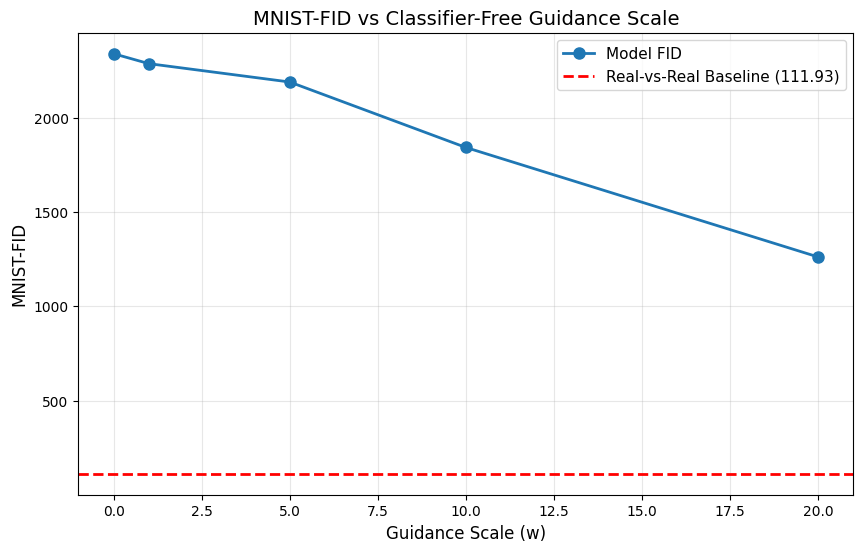

In [ ]:
# Ensure output directory exists
outputs_dir = PROJECT_ROOT / "outputs"
outputs_dir.mkdir(parents=True, exist_ok=True)

# Plot MNIST-FID vs Guidance Scale
plot_fid_vs_guidance(
    list(fid_results.keys()),
    list(fid_results.values()),
    baseline_fid=baseline_fid,
    save_path=str(outputs_dir / "mnist_fid_vs_guidance.png")
)

Saved accuracy plot to outputs/accuracy_vs_guidance.png


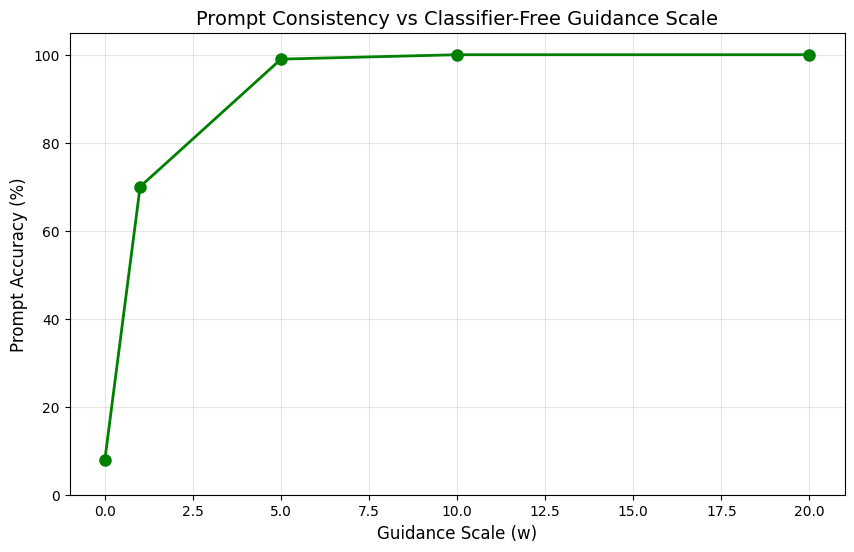

In [ ]:
# Plot Conditional Accuracy vs Guidance Scale
accuracies = [accuracy_results[w]['accuracy'] for w in sorted(accuracy_results.keys())]
plot_accuracy_vs_guidance(
    list(sorted(accuracy_results.keys())),
    accuracies,
    save_path=str(outputs_dir / "accuracy_vs_guidance.png")
)

In [ ]:
# Visualize sample predictions for a specific guidance scale
GUIDANCE_TO_VISUALIZE = 8  # Choose one to visualize in detail

if GUIDANCE_TO_VISUALIZE in generated_samples_cache:
    images, targets = generated_samples_cache[GUIDANCE_TO_VISUALIZE]
    acc_data = accuracy_results[GUIDANCE_TO_VISUALIZE]
    
    print(f"Visualizing predictions for guidance scale w={GUIDANCE_TO_VISUALIZE}")
    visualize_conditional_accuracy(
        images,
        targets,
        acc_data['predictions'],
        acc_data['confidences'],
        num_samples=30,
        save_path=str(outputs_dir / f"predictions_w{GUIDANCE_TO_VISUALIZE}.png")
    )
else:
    print(f"Guidance scale {GUIDANCE_TO_VISUALIZE} not in cache. Available: {list(generated_samples_cache.keys())}")

Guidance scale 8 not in cache. Available: [0, 1, 5, 10, 20]


Best guidance scale (by accuracy): w=10 (100.00%)
Saved confusion matrix to outputs/confusion_matrix_w10.png


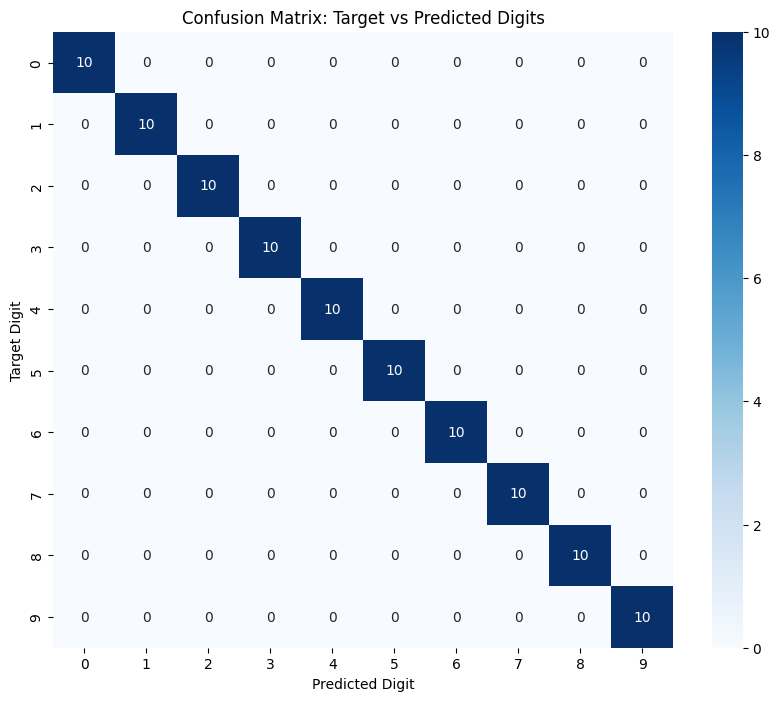

In [ ]:
# Confusion matrix for best guidance scale (highest accuracy)
best_guidance = max(accuracy_results.keys(), key=lambda w: accuracy_results[w]['accuracy'])
print(f"Best guidance scale (by accuracy): w={best_guidance} ({accuracy_results[best_guidance]['accuracy']:.2f}%)")

acc_data = accuracy_results[best_guidance]
plot_confusion_matrix(
    acc_data['targets'],
    acc_data['predictions'],
    save_path=str(outputs_dir / f"confusion_matrix_w{best_guidance}.png")
)

## Step 6: Generate Comprehensive Report

Summary of all evaluation metrics.

In [ ]:
# Generate and save comprehensive evaluation report
outputs_dir = PROJECT_ROOT / "outputs"
outputs_dir.mkdir(parents=True, exist_ok=True)

report = generate_evaluation_report(
    fid_results=fid_results,
    accuracy_results=accuracy_results,
    baseline_fid=baseline_fid,
    num_samples=NUM_SAMPLES_PER_DIGIT * 10,
    save_path=str(outputs_dir / "mnist_evaluation_report.txt")
)

print(f"\nEvaluation complete! All results saved to {outputs_dir}/")

MNIST Text-to-Image Diffusion Model Evaluation Report
Number of samples: 100
Real-vs-Real Baseline FID: 111.93

----------------------------------------------------------------------
MNIST-FID Results (lower is better)
----------------------------------------------------------------------
Guidance Scale w=  0: FID = 2340.00
Guidance Scale w=  1: FID = 2287.32
Guidance Scale w=  5: FID = 2189.91
Guidance Scale w= 10: FID = 1842.67
Guidance Scale w= 20: FID = 1261.67

----------------------------------------------------------------------
Conditional Accuracy Results (higher is better)
----------------------------------------------------------------------
Guidance Scale w=  0: Accuracy =   8.00%
  Per-digit accuracy:
    Digit 0:   0.00%
    Digit 1:   0.00%
    Digit 2:  10.00%
    Digit 3:  20.00%
    Digit 4:   0.00%
    Digit 5:   0.00%
    Digit 6:   0.00%
    Digit 7:   0.00%
    Digit 8:  10.00%
    Digit 9:  40.00%

Guidance Scale w=  1: Accuracy =  70.00%
  Per-digit accuracy:
  

## Summary & Interpretation

### What the metrics mean:

**MNIST-FID (lower is better):**
- Measures distribution similarity between real and generated images in MNIST-relevant feature space
- Compare to real-vs-real baseline to see if model is close to natural variation
- Much better than Inception-FID for MNIST since it uses digit-specific features

**Conditional Accuracy (higher is better):**
- Measures if generated images match the prompt digit
- Shows how well the model follows text conditioning
- Per-digit breakdown reveals if certain digits are harder to generate

**Guidance Scale Tradeoffs:**
- Low guidance (w≈1-2): More diverse but less accurate to prompts
- High guidance (w≈10-20): More accurate to prompts but potentially less diverse
- Sweet spot typically around w=5-10 for good balance

### Expected results:
- MNIST-FID should ideally be close to the real-vs-real baseline (within 10-50 points)
- Conditional accuracy should increase with guidance scale
- Digits like 1 and 7 are typically easier; 5, 8, 9 may be harder

### Next steps:
- Experiment with different guidance scales
- Try increasing NUM_SAMPLES_PER_DIGIT for more stable metrics (>=1000 recommended)
- Analyze failure cases in the confusion matrix
- Compare results with different checkpoint epochs